# <font color='red'>1. Introduction </font>

Nous sommes impliqués dans un projet visant à examiner les facteurs influençant le taux de rotation des employés chez HumanForYou, une entreprise pharmaceutique indienne. Avec un taux de rotation annuel d'environ 15 %, nous cherchons à identifier les causes sous-jacentes et à élaborer des stratégies pour le réduire. Ce taux élevé de rotation présente plusieurs inconvénients pour l'entreprise, notamment des retards dans les projets, un besoin important en ressources humaines pour le recrutement, et le temps nécessaire à la formation des nouveaux employés jusqu'à ce qu'ils atteignent leur pleine productivité.

Pour atteindre cet objectif, l'entreprise nous a fourni plusieurs ensembles de données anonymisées contenant des informations sur les employés, leurs évaluations par les managers, leur satisfaction au travail et leurs horaires de travail pour l'année 2015. Ces données couvrent divers aspects tels que l'âge, le sexe, le niveau d'éducation, le domaine d'études, le salaire mensuel, le nombre d'années passées dans l'entreprise, ainsi que la satisfaction à l'égard de l'environnement de travail, du poste occupé et de l'équilibre travail-vie personnelle.

Notre mission en tant qu'analystes de données comprend plusieurs étapes clés :

1. Générer et justifier le traitement des jeux de données pour aborder la problématique.
2. Sélectionner et justifier les algorithmes d'intelligence artificielle à utiliser.
3. Analyser et interpréter les résultats obtenus à l'aide de ces algorithmes, en s'appuyant sur des métriques appropriées.
4. Proposer une démarche pour améliorer les modèles d'IA développés.
5. Déterminer le modèle final en fonction des besoins spécifiques de l'entreprise et des analyses effectuées.
6. Émettre des recommandations basées sur l'analyse pour aider l'entreprise à réduire son taux de rotation.

Nous sommes attendus pour présenter nos résultats et recommandations à travers une présentation intégrant un notebook Jupyter, démontrant l'ensemble de notre démarche analytique et les conclusions que nous avons tirées.

# <font color='red'>2. Préparation de l'environnement </font>
## <font color='green'>2.1 Import des dépendances </font>

In [10]:
# Importations standard et pour la manipulation des données
import os
import pandas as pd
import numpy as np
from datetime import datetime
from cmath import phase, rect
from math import radians, degrees
from pandas.plotting import scatter_matrix

# Importations pour la visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Importations pour le machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc

# Configuration de Seaborn pour les visualisations
sns.set(style="whitegrid")

# Ignorer les avertissements inutiles pour nettoyer la sortie
import warnings
warnings.filterwarnings("ignore")


## <font color='green'>2.2 Import des données</font>
Cinq ensembles de données sont chargés en utilisant la fonction pd.read_csv() de la bibliothèque pandas, une bibliothèque puissante pour la manipulation et l'analyse des données en Python. Chaque fichier CSV est lu et stocké dans un DataFrame pandas distinct, ce qui permet une manipulation aisée des données pour l'analyse ultérieure. Les DataFrames créés sont :

- ***general*** contenant les données générales sur les employés (fichier general_data.csv).
- ***employe*** contenant les résultats de l'enquête sur les employés (fichier employee_survey_data.csv).
- ***manager*** contenant les résultats de l'enquête sur les managers (fichier manager_survey_data.csv).
- ***In*** contenant les données sur les horaires d'arrivée des employés (fichier in_time.csv).
- **Out** contenant les données sur les horaires de départ des employés (fichier out_time.csv).

In [11]:
path = "./data/"

general_data = pd.read_csv(path + "general_data.csv")
employe_data = pd.read_csv(path + "employee_survey_data.csv")
manager_data = pd.read_csv(path + "manager_survey_data.csv")
In_data = pd.read_csv(path + "in_time.csv")
Out_data = pd.read_csv(path + "out_time.csv")

#On fusionne les 3 fichiers de data
combined = general_data.merge(manager_data, how='right', on = 'EmployeeID')
final_data = combined.merge(employe_data, how='right', on = 'EmployeeID')

#On transforme tous les NA en 0
final_data.fillna(0, inplace=True)

# <font color='red'>3. Choix des données  </font>


## <font color='green'>3.1 Données inutiles</font>

Il est crucial d'adopter une approche méthodique pour identifier les données pertinentes à conserver dans notre analyse.

Dans cette optique, nous commencerons par cibler les colonnes du tableau *General_data* où chaque entrée présente une valeur uniforme, c'est-à-dire égale à 1. Cela signifie que tous les enregistrements dans ces colonnes sont identiques.

Pour repérer ces colonnes spécifiques, nous pouvons exécuter une fonction dédiée. Cette étape nous permettra de déterminer avec précision les champs qui remplissent ce critère.

In [12]:
for col in final_data.columns:
    value = final_data[col].nunique()
    value_of = final_data[col].unique()
    if value == 1:
        print(col)
        print(value_of)

EmployeeCount
[1]
Over18
['Y']
StandardHours
[8]


In [13]:
final_data = final_data.drop(columns=['EmployeeCount','Over18', 'StandardHours','EmployeeID'])

Nous avons opté pour l'élimination de la colonne ***EmployeeCount*** et ***StandardHours*** de notre jeu de données, car ces colonnes présentent une valeur unique pour l'ensemble du dataset, ce qui les rendent non pertinentes pour notre analyse.

Nous enlevons aussi ***Over18Y***, car tout les employés sont majeurs, comme l'impose la loi.

Nous supprimons ***EmployeeID*** car il s'agit juste d'un nombre incrémental, ce qui nous est inutle.

## <font color='green'>3.2 Conclusion </font>

Après avoir sélectionné les données à conserver en fonction de différents facteurs voici une liste exhaustive de celles conservées pour la réalisation de notre modèle :


<font color='blue'> General_data </font>

- **Attrition :** L'objet de notre étude, est-ce que l'employé a quitté l'entreprise durant l'année 2016 ?
<br>

- **BusinessTravel :** A quel fréquence l'employé a été amené à se déplacer dans le cadre de son travail en 2015 ? (Non-Travel = jamais, Travel_Rarely= rarement, Travel_Frequently = fréquemment)
<br>

- **DistanceFromHome :** Distance en km entre le logement de l'employé et l'entreprise.
<br>

- **Education : Niveau d'étude :** 1=Avant College (équivalent niveau Bac), 2=College (équivalent Bac+2), 3=Bachelor (Bac+3), 4=Master (Bac+5) et 5=PhD (Thèse de doctorat).
<br>

- **EducationField :** Domaine d'étude, matière principale
<br>

- **EmployeeId :** l'identifiant d'un employé
<br>

- **JobLevel :** Niveau hiérarchique dans l'entreprise de 1 à 5
<br>

- **JobRole :** Métier dans l'entreprise
<br>

- **MonthlyIncome :** Salaire brut en roupies par mois
<br>

- **NumCompaniesWorked :** Nombre d'entreprises pour lequel le salarié a travaillé avant de rejoindre HumanForYou.
<br>

- **PercentSalaryHike :** % d'augmentation du salaire en 2015.
<br>

- **StockOptionLevel :** Niveau d'investissement en actions de l'entreprise par le salarié.
<br>

- **TotalWorkingYears :** Nombre d'années d'expérience en entreprise du salarié pour le même type de poste.
<br>

- **TrainingTimesLastYear :** Nombre de jours de formation en 2015
<br>

- **YearsAtCompany :** Ancienneté dans l'entreprise
<br>

- **YearsSinceLastPromotion :** Nombre d'années depuis la dernière augmentation individuelle
<br>

- **YearsWithCurrentManager :** Nombre d'années de collaboration sous la responsabilité du manager actuel de l'employé.

<font color='blue'> Employee_survey_data </font>

- **L'environnement de travail :** : noté 1 ("Faible"), 2 ("Moyen"), 3 ("Élevé") ou 4 ("Très élevé") : EnvironmentSatisfaction
<br>

- **Son travail :** noté de 1 à 4 comme précédemment : JobSatisfaction
<br>

- **Son équilibre entre vie professionnelle et vie privée :** noté 1 ("Mauvais"), 2 ("Satisfaisant"), 3 ("Très satisfaisant") ou 4 ("Excellent") : WorkLifeBalance

<font color='blue'> Manager_survey_data </font>

- **Une évaluation de son implication dans son travail :** notée 1 ('Faible'), 2 ("Moyenne"), 3 ("Importante") ou 4 ("Très importante") : JobInvolvement
<br>

- **Une évaluation de son niveau de performance annuel pour l'entreprise :** notée 1 ("Faible"), 2 ("Bon"), 3 ("Excellent") ou 4 ("Au delà des attentes") : PerformanceRating

<font color='blue'> In_Time et Out_Time </font>

Nous allons conserver toutes les données de badgeuse d'entrée et de sortie afin d'effectuer différents statistiques sur ces données.

# <font color='red'>4. Manipulation des fichiers d'horaires de travail </font>

## <font color='green'>4.1 Calculs heures moyennes </font>

Nous allons traiter les fichiers relatifs aux horaires de travail afin de les rendre exploitables.

Tout d'abord, nous remplaçons les valeurs NaN par 0 (ce qui correspond donc aux jours de congés), puis nous vérifions que le nombre de jours de congés est le même dans les deux tables. Ensuite, nous affichons un histogramme pour obtenir une représentation visuelle.

In [14]:
#Remplace les valeurs NaN par 0 dans In
In_data.fillna(0, inplace=True)
#Remplace les valeurs NaN par 0 dans Out
Out_data.fillna(0, inplace=True)

#Calcul jour de congés
vac_In = (In_data == 0).astype(int).sum(axis=1)
vac_Out = (Out_data ==0).astype(int).sum(axis=1)
vac_In.equals(vac_Out)

True

In [15]:
#vac_In.hist(bins=50, figsize=(20,15))
#plt.xlabel("Nombre de jours de congés")
#plt.ylabel("Nombre d'employés")
#plt.show()

On supprime la première colonne des deux tableaux car elle est inutile.

In [16]:
In_data = In_data.drop(In_data.columns[0], axis = 1)
Out_data = Out_data.drop(Out_data.columns[0], axis = 1)

Nous calculons la moyenne des horaires d'arrivée et de départ des employés en convertissant les données en format datetime, en gérant les erreurs pour remplacer les valeurs inappropriées par NaT puis en calculant les temps moyens. 



In [17]:
In_h = In_data.iloc[:, 0:262].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))
Out_h = Out_data.iloc[:, 0:262].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S', errors='coerce'))

#Calculer la moyenne des angles, facilitant la moyenne des temps.
def mean_angle(deg):
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

#Cette fonction permet de déterminer le temps moyen d'arrivée ou de départ, en excluant les valeurs manquantes.
def mean_time(row):
    row = row.dropna()  # Supprimer les valeurs NaT
    if row.empty:
        return None  # Retourner None ou une valeur par défaut si la ligne est vide après la suppression des NaT
    t = ([time.hour, time.minute, time.second] for time in row)
    seconds = ((float(s) + int(m) * 60 + int(h) * 3600) for h, m, s in t)
    seconds = [i for i in seconds if i > 0]
    if not seconds:
        return None  # Retourner None ou une valeur par défaut si aucun second n'est > 0
    day = 24 * 60 * 60
    to_angles = [s * 360. / day for s in seconds]
    mean_as_angle = mean_angle(to_angles)
    mean_seconds = mean_as_angle * day / 360.
    if mean_seconds < 0:
        mean_seconds += day
    h, m = divmod(mean_seconds, 3600)
    m, s = divmod(m, 60)
    return '%02i:%02i:%02i' % (h, m, s)

#Heure d'arrivée moyenne
In_h['AverageInTime'] = In_h.apply(mean_time, axis=1)
#Heure de départ moyenne
Out_h['AverageOutTime'] = Out_h.apply(mean_time, axis=1)  # Correction du nom de colonne pour AverageOutTime


Nous calculons ensuite la durée moyenne de travail quotidien des employés en soustrayant l'heure moyenne d'arrivée (Average_In) de l'heure moyenne de départ (Average_Out).

In [18]:
Average_Out = pd.to_timedelta(Out_h['AverageOutTime'])
Average_In = pd.to_timedelta(In_h['AverageInTime'])

AverageTimeWorking = (Average_Out - Average_In)

## <font color='green'>4.2 Fusion des données </font>

On peut maintenant ajouter 2 nouvelles colonnes : la première correspondant au nombre de jours de congés pris par l'employé (***`Holidays`***), et la seconde au temps de travail moyen par jour de l'employé (***`AverageTimeWorking`***).

In [24]:
#On ajoute les vacances prises par les employés
final_data['Holidays'] = vac_In
#On ajoute le temps de travail moyen
final_data['AverageTimeWorking'] = AverageTimeWorking

final_data

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Holidays,AverageTimeWorking
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,1,0,0,3,3,3.0,4.0,2.0,29,0 days 07:22:25
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,5,1,4,2,4,3.0,2.0,4.0,25,0 days 07:43:08
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,5,0,3,3,3,2.0,2.0,1.0,19,0 days 07:00:47
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,8,7,5,2,3,4.0,4.0,3.0,26,0 days 07:11:37
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,6,0,4,3,3,4.0,1.0,3.0,16,0 days 08:00:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,Female,1,Research Scientist,...,3,0,2,3,3,4.0,1.0,3.0,18,0 days 08:31:20
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,Male,1,Laboratory Technician,...,3,0,2,2,3,4.0,4.0,3.0,20,0 days 06:05:34
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,Male,2,Sales Executive,...,4,1,2,3,4,1.0,3.0,3.0,30,0 days 07:42:24
4408,42,No,Travel_Rarely,Sales,18,2,Medical,Male,1,Laboratory Technician,...,9,7,8,2,3,4.0,1.0,3.0,20,0 days 09:29:34


On remarque que le temps de travail moyen n'est pas dans un format manipulable, nous allons donc le transofrmer en float. Pareil pour l'heure d'arrivée et de départ.

In [25]:
Time_float = final_data['AverageTimeWorking'].dt.seconds
Time_float = Time_float/3600
final_data['AverageTimeWorking'] = Time_float

# <font color='red'>5. Exploration des données </font>

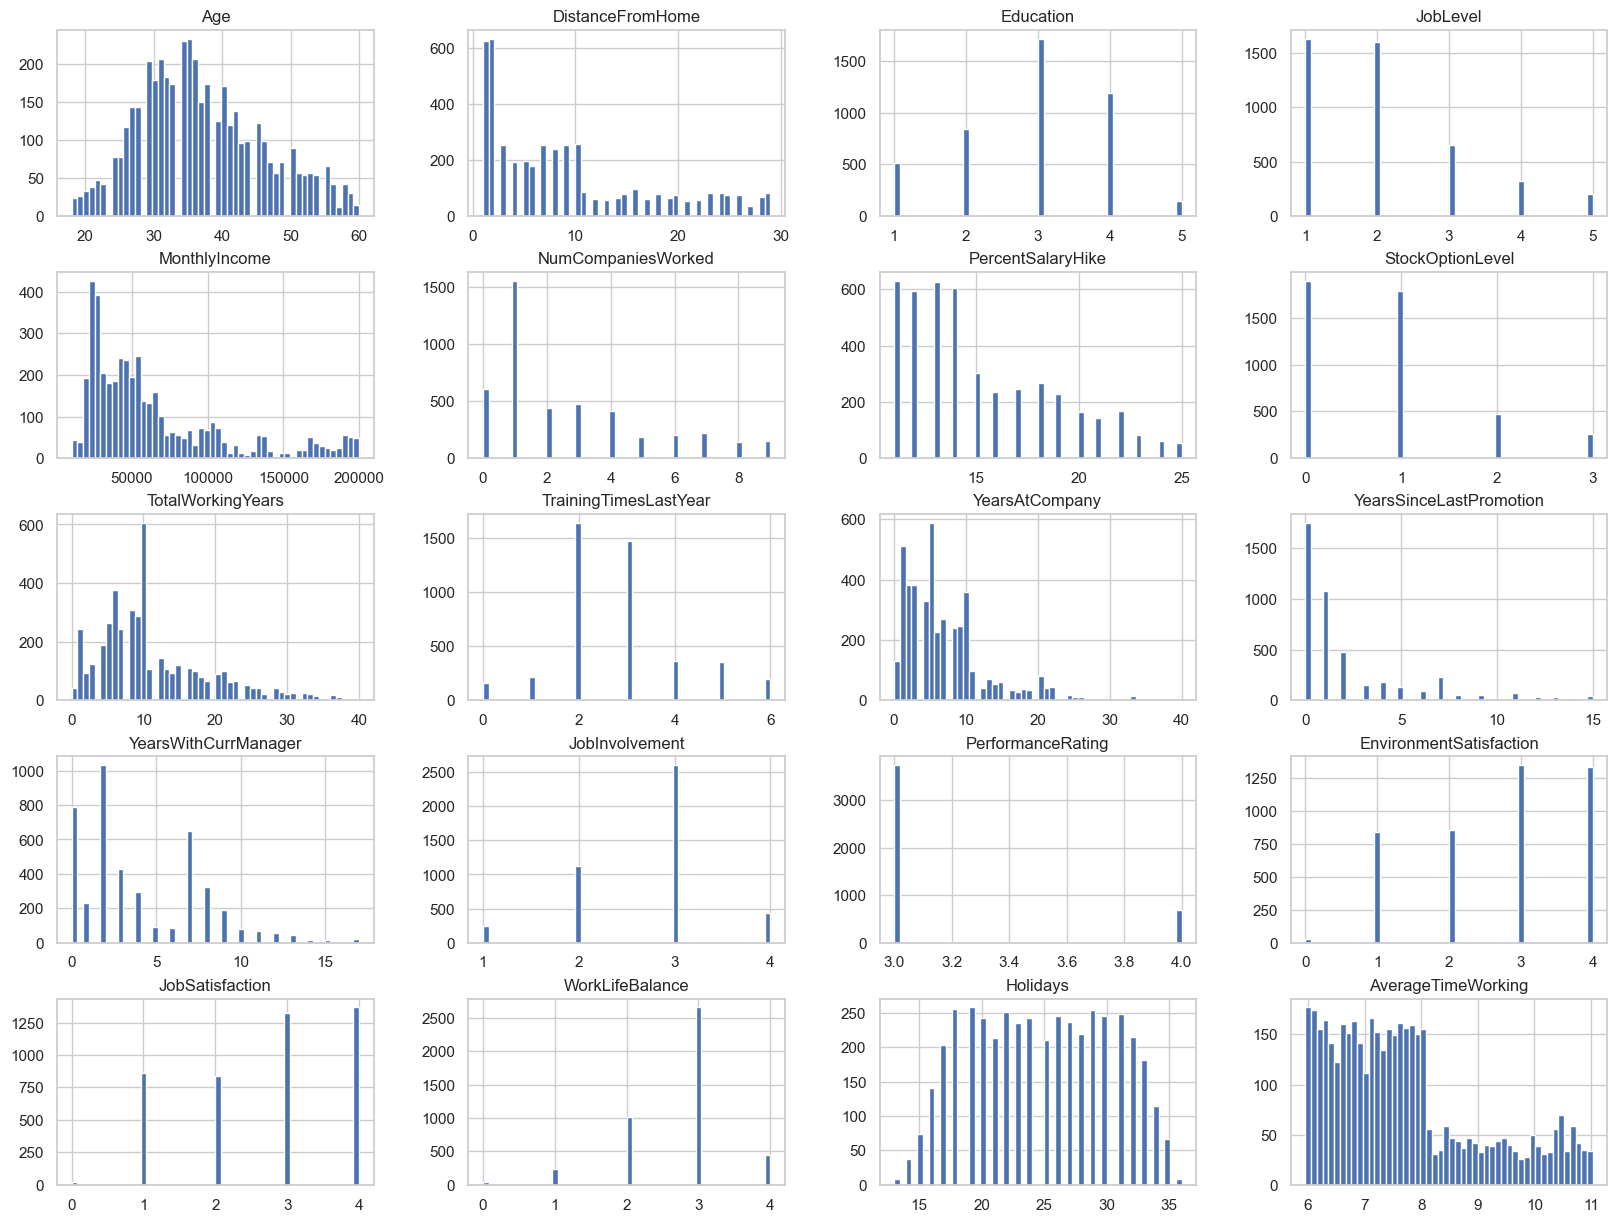

In [26]:
final_data.hist(bins=50, figsize=(20,15))
plt.show()

## <font color='green'>5.1 Matrice de corrélation </font>

In [28]:
df_encoded = final_data.copy()
# On applique l'encodage One-Hot aux variables catégorielles.
df_encoded = pd.get_dummies(final_data, columns=['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'Gender', 'MaritalStatus'])
#On transforme Attrition en binaire
df_encoded['Attrition'] = df_encoded['Attrition'].map({'Yes': 1, 'No': 0})
# On calcul la matrice de corrélation sur le DataFrame encodé
correlation_matrix = df_encoded.corr()
# On filtre pour sélectionner les colonnes générées par l'encodage de 'Attrition'
correlation_with_attrition = correlation_matrix.filter(regex='Attrition')
print(correlation_with_attrition)


                                   Attrition
Age                                -0.159205
Attrition                           1.000000
DistanceFromHome                   -0.009730
Education                          -0.015111
JobLevel                           -0.010290
MonthlyIncome                      -0.031176
NumCompaniesWorked                  0.041503
PercentSalaryHike                   0.032533
StockOptionLevel                   -0.006839
TotalWorkingYears                  -0.170238
TrainingTimesLastYear              -0.049431
YearsAtCompany                     -0.134392
YearsSinceLastPromotion            -0.033019
YearsWithCurrManager               -0.156199
JobInvolvement                     -0.015588
PerformanceRating                   0.023403
EnvironmentSatisfaction            -0.101517
JobSatisfaction                    -0.097982
WorkLifeBalance                    -0.053965
Holidays                           -0.043517
AverageTimeWorking                  0.201688
BusinessTr

Selon l'analyse de la matrice de corrélation, nous pouvons tirer plusieurs observations pertinentes pour notre recherche :

- Les variables ayant la corrélation négative la plus marquée avec Attrition comprennent ***TotalWorkingYears*** (-0,17), ***Age*** (-0,15), ***YearsAtCompany*** (-0,13), et ***YearsWithCurrManager*** (-0,15). Cela suggère qu'une plus grande longévité des employés au sein de l'entreprise ou auprès de leur manager actuel diminue leur propension à partir.
- D'autres indicateurs montrent également une corrélation négative notable avec Attrition, notamment ***EnvironmentSatisfaction*** (-0,10) et ***JobSatisfaction*** (-0,10). Cela indique que les employés qui se sentent satisfaits de leur environnement de travail ou de leur poste sont moins enclins à démissionner.
- Les facteurs présentant une corrélation positive significative avec Attrition sont ***AverageTimeWorking*** (0,20), ce qui indique une tendance pour les employés ayant des heures de travail prolongées à envisager de quitter l'entreprise et ***MaritalStatus_Single*** (0,17), ce qui signifie que les personnes seules ont tendance à quitter l'entreprise.

Il est crucial de rappeler que la corrélation n'implique pas systématiquement une relation de cause à effet. Une enquête approfondie sur les variables fortement corrélées à l'attrition est donc essentielle pour déceler les véritables motivations incitant les employés à quitter l'organisation.

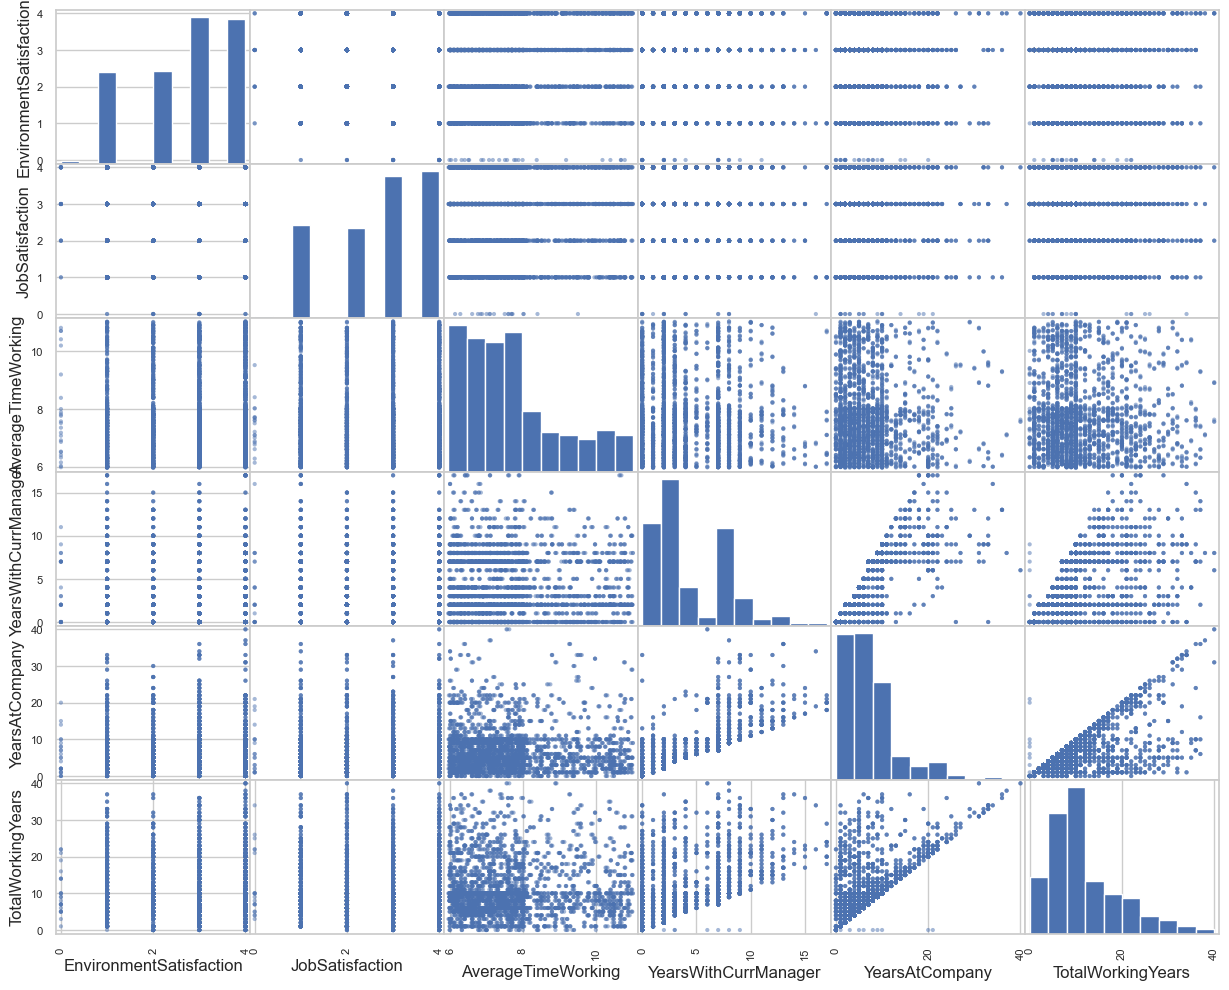

In [29]:
attributes = ["EnvironmentSatisfaction", "JobSatisfaction", "AverageTimeWorking", "YearsWithCurrManager", "YearsAtCompany", "TotalWorkingYears"]
scat_matrix = scatter_matrix(df_encoded[attributes], figsize=(15, 12))

# <font color='red'>6. Pipeline de transformation </font>

Dans ce code, nous avons entrepris la préparation des données pour un modèle de machine learning, en identifiant d'abord les caractéristiques numériques et catégorielles nécessaires à la transformation. Les caractéristiques numériques (num_features) comprennent des variables telles que le revenu mensuel, la distance domicile-travail, les années de travail totales, entre autres, tandis que les caractéristiques catégorielles (cat_features) incluent le voyage d'affaires, le département, le domaine d'éducation, etc.

Nous avons ensuite créé des pipelines séparés pour le traitement des caractéristiques numériques et catégorielles. Le pipeline numérique (num_pipeline) utilise un imputateur pour remplacer les valeurs manquantes par la moyenne et un normalisateur pour standardiser les caractéristiques. Le pipeline catégoriel (cat_pipeline), quant à lui, applique un encodage one-hot pour gérer les variables catégorielles.

Ces pipelines sont combinés dans un transformateur de colonnes (ColumnTransformer), formant un préprocesseur complet qui effectue simultanément les transformations numériques et catégorielles sur les données.

Le dataset est ensuite divisé en caractéristiques (X) et cible (y), avec y étant binarisée pour refléter l'attrition comme une variable binaire (1 pour 'Yes', 0 pour 'No').

Nous vérifions enfin l'existence des colonnes référencées dans X pour s'assurer que toutes les colonnes nécessaires sont présentes, en affichant les colonnes manquantes le cas échéant. Cette étape est cruciale pour éviter les erreurs lors de l'application du préprocesseur sur le dataset, garantissant que les transformations sont appliquées correctement à toutes les caractéristiques spécifiées.

In [30]:
# Identification des colonnes pour chaque transformation
num_features = ['Age', 'MonthlyIncome', 'DistanceFromHome', 'TotalWorkingYears', 
                'NumCompaniesWorked', 'YearsAtCompany', 'Holidays', 'AverageTimeWorking']

cat_features = ['BusinessTravel','Department' , 'EducationField', 'JobRole', 'Gender', 'MaritalStatus']

# Création des pipelines pour les transformations numériques et catégorielles
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Assemblage du pipeline complet
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Division du dataset
X = final_data.drop('Attrition', axis=1)
y = final_data['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)  # Conversion de la cible en binaire


# Vérifiez si toutes les colonnes référencées existent dans X
#print(X.columns)
#missing_cols_num = [col for col in num_features if col not in X.columns]
#missing_cols_cat = [col for col in cat_features if col not in X.columns]
#print("Colonnes numériques manquantes:", missing_cols_num)
#print("Colonnes catégorielles manquantes:", missing_cols_cat)

# <font color='red'>7. Algorithmes de Machine Learning  </font>
Notre pipeline de prétraitement des données est désormais prêt, intégrant soigneusement les transformations nécessaires pour les caractéristiques numériques et catégorielles. Cette étape cruciale nous permet d'assurer que les données sont correctement formatées et normalisées pour l'application des modèles d'apprentissage automatique. Avec cette préparation achevée, nous pouvons maintenant passer à la phase suivante de notre projet : la sélection et l'application des algorithmes de machine learning. 

## <font color='green'>7.1 Méthode des k plus proches voisins (KNN)</font>

La méthode des k plus proches voisins (KNN) est un algorithme d'apprentissage supervisé simple et intuitif utilisé pour la classification et la régression. Son principe de base consiste à trouver les k échantillons les plus proches (ou voisins) d'un point de données non classifié dans l'espace des caractéristiques, puis à prédire son étiquette (pour la classification) ou sa valeur (pour la régression) en se basant sur la majorité ou la moyenne des étiquettes ou valeurs de ces voisins. La distance entre les points de données, souvent calculée par la distance euclidienne, est utilisée pour déterminer les voisins les plus proches. L'efficacité de KNN dépend du choix de k (le nombre de voisins) et de la mesure de distance utilisée. Bien qu'il soit facile à comprendre et à mettre en œuvre, KNN peut devenir inefficace en termes de temps et de mémoire avec de grands ensembles de données, car il nécessite de calculer la distance à chaque point de données lors de la prédiction.

### Entrainement du modèle

In [31]:
# Création d'un pipeline intégrant le préprocesseur et le modèle KNN
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

In [32]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement du modèle
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'JobRole',
                                                   'Gender',
                                                   'MaritalStatus'])])),
                ('classifier', KNeighborsClassifier())])

### Prédictions

In [33]:
# Prédictions sur l'ensemble de test
y_pred = knn_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8631897203325775

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.96      0.92      1115
           1       0.62      0.35      0.44       208

    accuracy                           0.86      1323
   macro avg       0.75      0.65      0.68      1323
weighted avg       0.84      0.86      0.85      1323




Les résultats obtenus avec l'algorithme des k plus proches voisins (KNN) pour notre projet de prédiction de l'attrition des employés indiquent une précision globale de 86,3%. Cette précision représente la proportion d'employés correctement classés par le modèle par rapport à l'ensemble total des prédictions.

Malgré la haute précision globale du modèle KNN, une analyse détaillée révèle des limitations, notamment dans la détection de l'attrition des employés. Cela met en évidence l'importance d'envisager d'autres modèles ou d'ajuster les paramètres du KNN pour améliorer la sensibilité du modèle aux cas d'attrition.







### Matrice de confusion

La matrice de confusion montre les prédictions correctes et incorrectes du modèle en détail. Elle est particulièrement utile pour voir comment le modèle performe pour chaque classe.

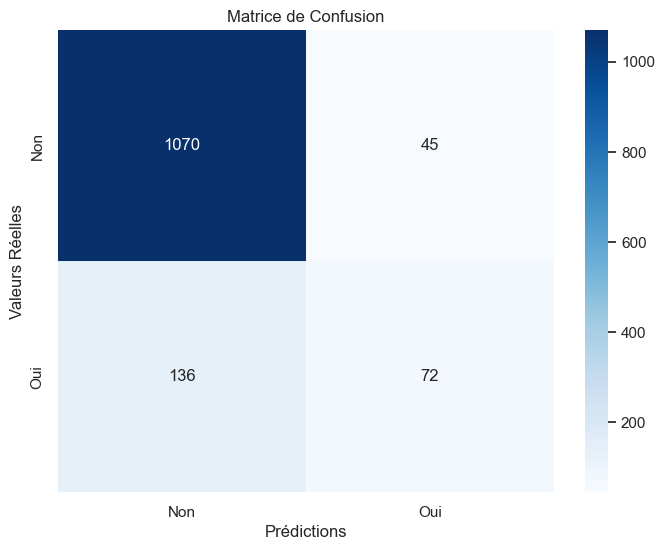

In [34]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

Le modèle a une forte tendance à correctement identifier les employés qui restent (TN élevé), mais il est moins performant pour identifier correctement ceux qui quittent l'entreprise (VP plus faible par rapport au FN). Le nombre élevé de FN indique que le modèle pourrait être amélioré pour mieux détecter les cas d'attrition. Les FP relativement bas indiquent que le modèle ne fait pas beaucoup d'erreurs en classant faussement les employés comme partants.

### ROC Curve

La courbe Receiver Operating Characteristic (ROC) et l'Area Under the Curve (AUC) évaluent la performance du modèle dans les tâches de classification binaire à différents seuils. Ces métriques sont utiles pour évaluer la capacité du modèle à distinguer entre les classes.

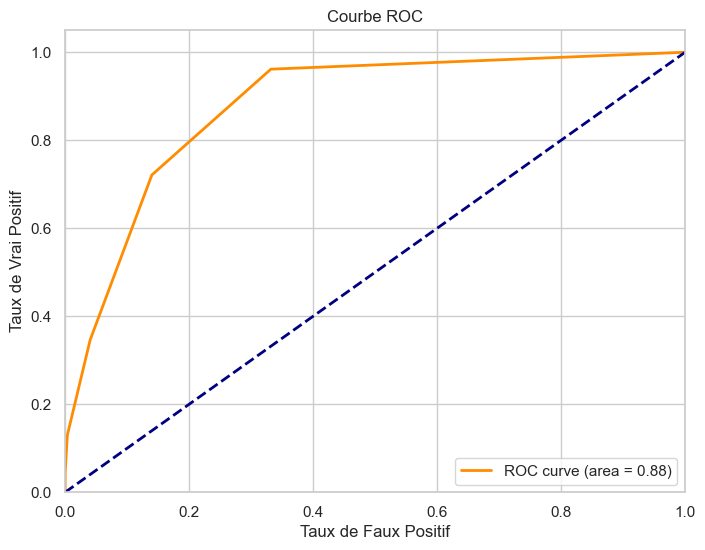

In [35]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, knn_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

Avec une AUC de 0.88, cela signifie que le modèle a une très bonne capacité à différencier entre les employés qui vont quitter l'entreprise et ceux qui vont rester.

### Conclusion
L'utilisation de KNN pour notre projet montre un potentiel prometteur mais avec des axes d'amélioration. Il peut être nécessaire d'ajuster le nombre de voisins k, d'expérimenter avec différentes métriques de distance, ou d'employer des techniques de rééquilibrage de classe pour améliorer la sensibilité du modèle aux cas d'attrition. Il serait également judicieux de comparer KNN à d'autres modèles de classification pour s'assurer que nous utilisons le meilleur outil possible pour nos besoins spécifiques.

## <font color='green'>7.2 Random forest</font>

Random Forest est un algorithme d'apprentissage supervisé polyvalent et robuste utilisé pour la classification et la régression. Il fonctionne en construisant un grand nombre d'arbres de décision lors de la phase d'entraînement et en produisant la classe qui est le mode des classes (classification) ou la moyenne des prédictions (régression) des arbres individuels. Random Forest est un exemple d'ensemble learning, où la combinaison des résultats de multiples modèles vise à produire une prédiction finale plus précise et plus stable.

### Entrainement du modèle

In [36]:
# Création d'un pipeline intégrant le préprocesseur et le modèle KNN
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [37]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement du modèle
random_forest_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'JobRole',
                                                   'Gender',
                                                   'MaritalStatus'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

### Prédictions

In [38]:
# Prédictions sur l'ensemble de test
y_pred = random_forest_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9697656840513983

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1115
           1       0.98      0.82      0.90       208

    accuracy                           0.97      1323
   macro avg       0.98      0.91      0.94      1323
weighted avg       0.97      0.97      0.97      1323



Les résultats obtenus avec l'algorithme Random Forest pour notre projet de prédiction de l'attrition des employés sont très positifs.

Avec une précision globale de 97%, le modèle Random Forest a réussi à prédire correctement si un employé allait quitter ou non l'entreprise dans la grande majorité des cas. Cette haute précision indique une adéquation forte entre les prédictions du modèle et les valeurs réelles.

### Matrice de confusion


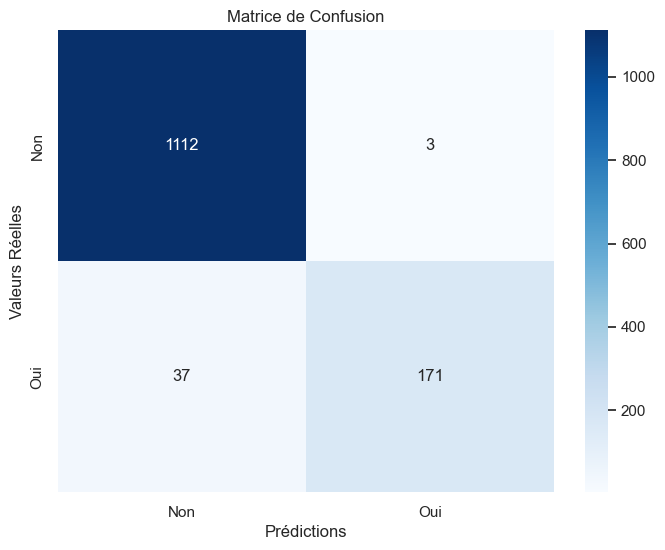

In [39]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

Cette matrice révèle que le modèle Random Forest a une excellente capacité à reconnaître les employés qui resteront dans l'entreprise, avec un taux très élevé de vrais négatifs et un nombre très faible de faux positifs. La performance est également très bonne pour identifier les employés qui partent, avec un nombre élevé de vrais positifs par rapport aux faux négatifs, bien que cet aspect puisse encore être amélioré.

### ROC Curve

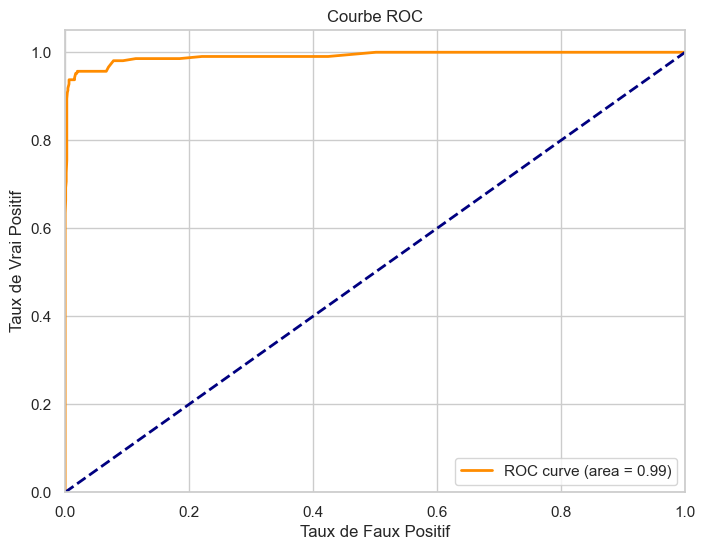

In [40]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, random_forest_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()


Cette courbe ROC, couplée à une AUC de 0.99, suggère que le modèle est très performant et qu'il offre une confiance élevée dans ses prédictions. Dans la pratique, cela signifie que les stratégies de rétention des employés fondées sur les prédictions de ce modèle ont une grande chance de cibler correctement les individus à risque. Il est rare d'obtenir de tels résultats, ce qui peut aussi inciter à une vérification approfondie pour s'assurer qu'il n'y a pas de surajustement ou de biais dans le modèle ou les données.

In [41]:
# Obtenir les noms de caractéristiques après prétraitement
feature_names = preprocessor.get_feature_names_out()

# Récupérer le modèle RandomForest du pipeline
rf_clf = random_forest_pipeline.named_steps['classifier']

# Créer la série des importances des caractéristiques avec les noms corrects
feature_importances = pd.Series(rf_clf.feature_importances_, index=feature_names).sort_values(ascending=False)

print("Importances des caractéristiques:\n\n", feature_importances)


Importances des caractéristiques:

 num__AverageTimeWorking                   0.143471
num__Age                                  0.103579
num__MonthlyIncome                        0.098921
num__TotalWorkingYears                    0.098482
num__YearsAtCompany                       0.083899
num__DistanceFromHome                     0.072050
num__NumCompaniesWorked                   0.056402
num__Holidays                             0.044501
cat__MaritalStatus_Single                 0.027437
cat__BusinessTravel_Travel_Frequently     0.015896
cat__JobRole_Research Scientist           0.015689
cat__EducationField_Life Sciences         0.015633
cat__Gender_Male                          0.015092
cat__EducationField_Medical               0.014240
cat__Gender_Female                        0.014131
cat__Department_Sales                     0.013554
cat__MaritalStatus_Married                0.013483
cat__JobRole_Sales Executive              0.013260
cat__JobRole_Laboratory Technician        0.01

Dans ce modèle de Random Forest qui prédit la probabilité qu'un employé quitte l'entreprise, les caractéristiques les plus déterminantes sont le temps moyen passé au travail, l'âge, le revenu mensuel et le nombre total d'années travaillées. Cela implique que les questions de durée de travail, de salaire et de longévité dans la carrière sont des facteurs cruciaux qui influencent le départ d'un employé.

### Conclusion

La performance globale du modèle Random Forest, illustrée par la courbe ROC, la matrice de confusion et les métriques de précision, est nettement supérieure à celle que nous avons observée avec le modèle KNN.

Le Random Forest a démontré une bonne capacité à distinguer entre les employés qui vont quitter l'entreprise et ceux qui vont rester, comme en témoigne son AUC presque parfaite. Les erreurs de classification sont minimales, et les mesures de précision et de rappel indiquent que le modèle est à la fois précis et sensible dans ses prédictions.

En comparaison, bien que le KNN ait fourni des résultats satisfaisants, le Random Forest se distingue par une performance supérieure et une fiabilité accrue. La différence entre les deux modèles pourrait être attribuée à la capacité du Random Forest à gérer les caractéristiques complexes et les interactions non linéaires entre elles, ce qui est souvent le cas dans les données réelles.

## <font color='green'>7.3 Régression Logistique</font>.

### Entrainement du modèle

In [42]:
# Création d'un pipeline intégrant le préprocesseur et le modèle de régression logistique
Logistic_regression_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [43]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrainement du modèle
Logistic_regression_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'JobRole',
                                                   'Gender',
                                                   'MaritalStatus'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

### Prédictions

In [44]:
# Prédictions sur l'ensemble de test
y_pred = Logistic_regression_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8526077097505669

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1115
           1       0.58      0.22      0.32       208

    accuracy                           0.85      1323
   macro avg       0.73      0.59      0.62      1323
weighted avg       0.82      0.85      0.82      1323



### Matrice de confusion

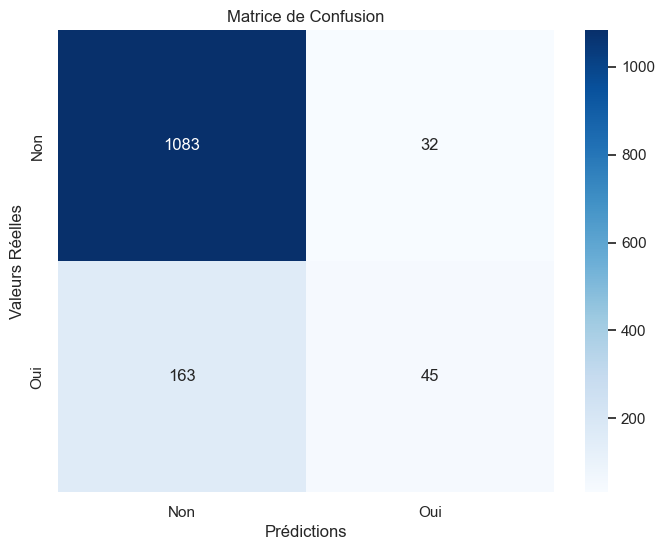

In [45]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

### ROC Curve

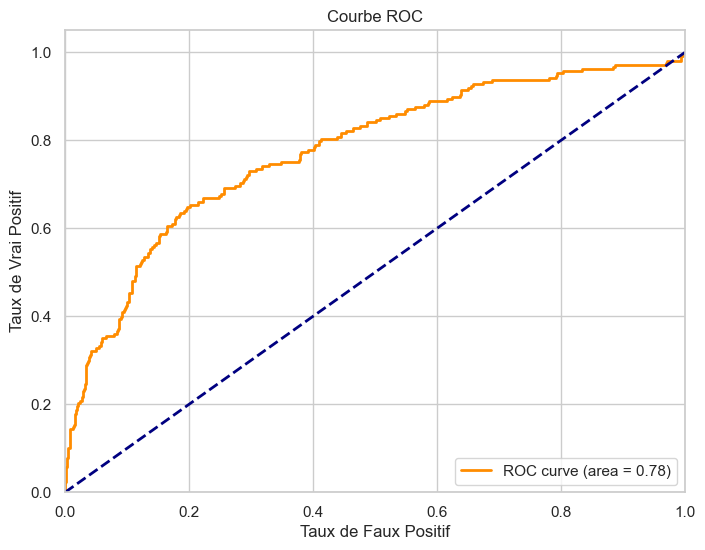

In [46]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, Logistic_regression_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### Conclusion 


Les résultats montrent que le modèle de régression logistique a une performance solide pour identifier les employés qui resteront dans l'entreprise, mais il lutte pour prédire correctement ceux qui sont susceptibles de partir, ce qui est évident à travers le faible score de rappel pour la classe positive. La courbe ROC indique une capacité discriminative acceptable du modèle, mais il y a une marge d'amélioration pour équilibrer la sensibilité et la spécificité. Le rapport de classification révèle également que le modèle penche en faveur de la classe majoritaire, ce qui peut conduire à un nombre significatif de faux négatifs. Ces éléments suggèrent que, bien que la régression logistique puisse être utile pour certaines prédictions, elle nécessite un ajustement ou l'application de techniques de balance des classes pour mieux détecter les cas de départ des employés.

## <font color='green'>7.4 Perceptron</font>


Le perceptron est un type d'algorithme d'apprentissage automatique qui représente la forme la plus simple d'un réseau de neurones artificiels. Il est conçu pour effectuer des classifications binaires, c'est-à-dire prédire si une entrée appartient à l'une des deux catégories possibles. Le fonctionnement du perceptron est basé sur la somme pondérée des entrées; chaque entrée est multipliée par un poids et la somme totale est passée à travers une fonction d'activation, comme la fonction d'escalier, qui décide de la sortie. Si la sortie est incorrecte, les poids sont ajustés pour améliorer la précision des prédictions futures. Le perceptron est un modèle linéaire, ce qui signifie qu'il ne peut apprendre que des relations linéairement séparables.

### Entrainement du modèle

In [47]:
perceptron_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', Perceptron(max_iter=1000, tol=1e-3))
])

In [48]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrainement du modèle
perceptron_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'JobRole',
                                                   'Gender',
                                                   'MaritalStatus'])])),
                ('classifier', Perceptron())])

### Prédictions

In [49]:
# Prédictions sur l'ensemble de test
y_pred = perceptron_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.763416477702192

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.82      0.85      1115
           1       0.33      0.47      0.39       208

    accuracy                           0.76      1323
   macro avg       0.61      0.64      0.62      1323
weighted avg       0.80      0.76      0.78      1323



Les résultats obtenus avec le modèle Perceptron pour notre projet de prédiction de l'attrition des employés sont en partie encourageants, mais révèlent également des défis à relever.

Avec une précision globale de 76.3%, le modèle Perceptron a réussi à prédire avec succès si un employé allait quitter ou non l'entreprise dans une proportion significative des cas. Cependant, il est important de noter que cette précision peut être améliorée pour une meilleure fiabilité des prédictions.


### Matrice de confusion

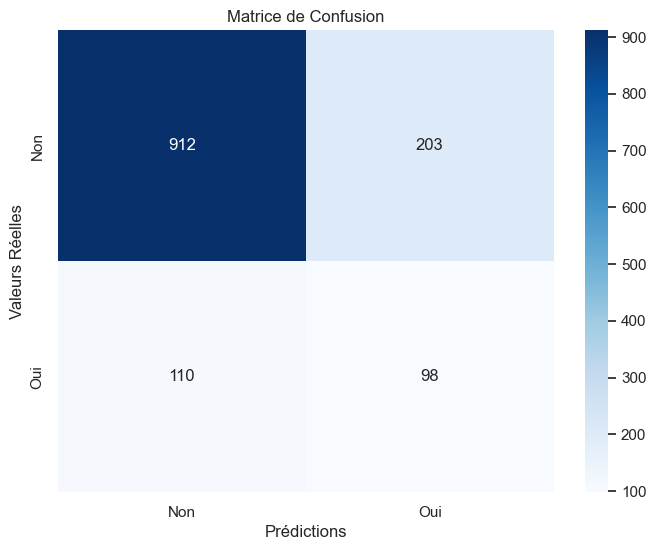

In [50]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)  # Utilisez y_pred_best si vous avez fait de l'optimisation hyperparamètre
# Ou utilisez y_pred pour le modèle sans optimisation

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

Cette matrice met en évidence les défis rencontrés par le modèle de Perceptron dans la prédiction de l'attrition des employés. Bien qu'il ait réussi à identifier un nombre significatif d'employés restant dans l'entreprise, il présente un taux élevé de faux positifs et de faux négatifs. Ces résultats suggèrent que des ajustements ou des améliorations sont nécessaires pour renforcer la capacité du modèle à prévoir avec précision les mouvements du personnel.

### ROC Curve

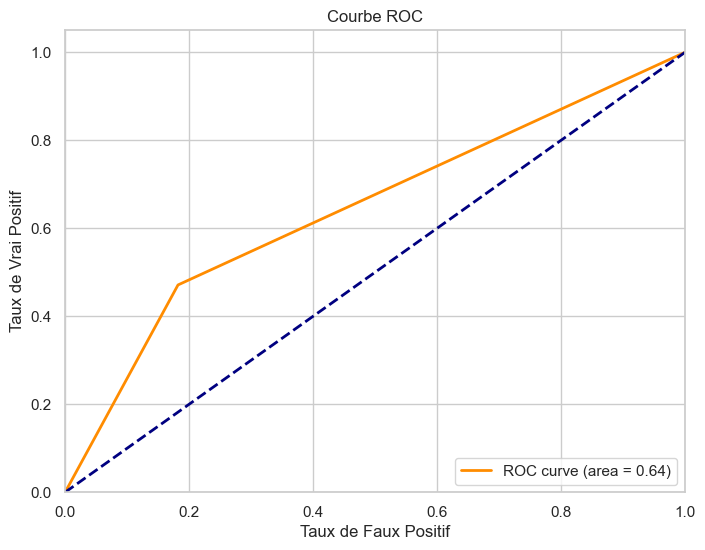

In [51]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, y_pred)


# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

## <font color='green'>7.5 Perceptron Multicouche</font>

Le Perceptron Multi-Couches (PMC) est un réseau de neurones artificiels pour l'apprentissage supervisé, adapté à la classification et la régression. Il comprend une série de couches : une couche d'entrée, plusieurs cachées, et une de sortie. Pendant l'entraînement, le PMC ajuste les poids entre les neurones via la rétropropagation pour réduire l'erreur de prédiction. Cette structure permet au PMC de modéliser des relations complexes entre les entrées et les sorties, rendant cet algorithme efficace pour une large gamme de problèmes.

### Entrainement du modèle

In [52]:
mlp_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, alpha=1e-4,
                                 solver='sgd', verbose=10, tol=1e-4, random_state=1,
                                 learning_rate_init=.1))
])

In [53]:
# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraînement du pipeline
mlp_pipeline.fit(X_train, y_train)

Iteration 1, loss = 0.45251253
Iteration 2, loss = 0.38188215
Iteration 3, loss = 0.36666880
Iteration 4, loss = 0.35535297
Iteration 5, loss = 0.34813970
Iteration 6, loss = 0.34076382
Iteration 7, loss = 0.33514681
Iteration 8, loss = 0.32858898
Iteration 9, loss = 0.32322387
Iteration 10, loss = 0.31903454
Iteration 11, loss = 0.31144644
Iteration 12, loss = 0.30413897
Iteration 13, loss = 0.29749483
Iteration 14, loss = 0.29508013
Iteration 15, loss = 0.28555992
Iteration 16, loss = 0.28090829
Iteration 17, loss = 0.27226406
Iteration 18, loss = 0.26576770
Iteration 19, loss = 0.26048511
Iteration 20, loss = 0.25649309
Iteration 21, loss = 0.24681996
Iteration 22, loss = 0.24326754
Iteration 23, loss = 0.23192198
Iteration 24, loss = 0.23032521
Iteration 25, loss = 0.22207236
Iteration 26, loss = 0.21767525
Iteration 27, loss = 0.21082094
Iteration 28, loss = 0.20540878
Iteration 29, loss = 0.19823060
Iteration 30, loss = 0.19573918
Iteration 31, loss = 0.18402722
Iteration 32, los

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'MonthlyIncome',
                                                   'DistanceFromHome',
                                                   'TotalWorkingYears',
                                                   'NumCompaniesWorked',
                                                   'YearsAtCompany', 'Holidays',
                                                   'AverageTimeWorking']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'JobRole',
                                                   'Gender',
                                                   'MaritalStatus'])])),
                ('classifier',
                 MLPClassifier(learning_rate_init=0.1, max_iter=1000,
                               random_state=1, solver='sgd', verbose=10))])

### Prédictions

In [54]:
# Prédictions sur l'ensemble de test
y_pred = mlp_pipeline.predict(X_test)

# Évaluation du modèle
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9780801209372638

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1115
           1       0.96      0.89      0.93       208

    accuracy                           0.98      1323
   macro avg       0.97      0.94      0.96      1323
weighted avg       0.98      0.98      0.98      1323



### Matrice de confusion

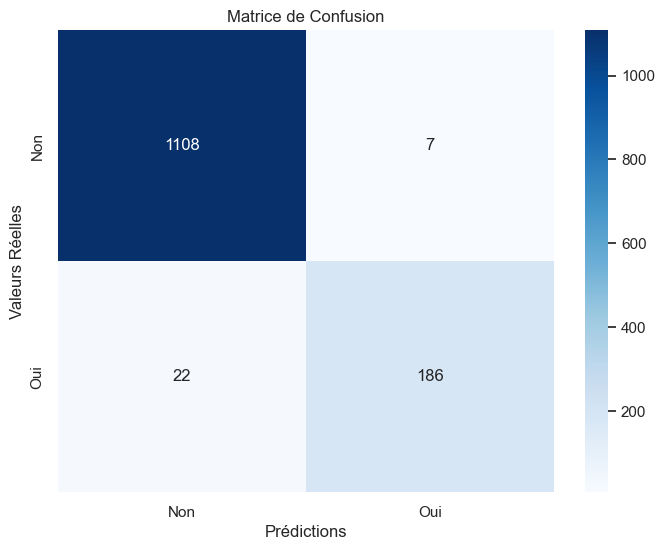

In [55]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non', 'Oui'], yticklabels=['Non', 'Oui'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

Cette matrice de confusion illustre les performances nettement améliorées d'un modèle de Perceptron Multi-Couches dans la tâche de prédiction de l'attrition des employés. On observe une réduction considérable du nombre de faux positifs et de faux négatifs. Cela indique que le PMC a une meilleure capacité à distinguer les employés susceptibles de quitter l'entreprise de ceux qui y resteront. Les résultats soulignent l'efficacité du PMC pour fournir des prévisions plus précises, ce qui peut être extrêmement utile pour la planification des ressources humaines et la rétention des talents.

### ROC Curve

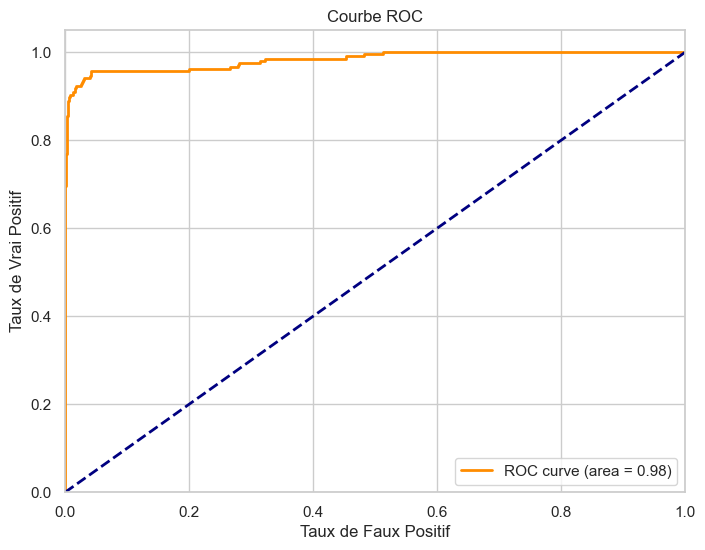

In [56]:
# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_test, mlp_pipeline.predict_proba(X_test)[:,1])

# Calcul de l'aire sous la courbe ROC
roc_auc = auc(fpr, tpr)

# Affichage de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positif')
plt.ylabel('Taux de Vrai Positif')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

### Conclusion

La courbe ROC pour le Perceptron Multi-Couches (PML) affiche une performance exceptionnelle avec une aire sous la courbe (AUC) de 0.98, indiquant une excellente capacité du modèle à distinguer entre les employés qui vont quitter et ceux qui vont rester. Cette haute valeur de l'AUC suggère que le PML a une sensibilité et une spécificité élevées, ce qui est idéal pour les tâches de classification binaires.Ces résultats montrent que le PML est un modèle robuste pour la prédiction de l'attrition, et peut être considéré comme fiable pour les décisions de gestion des ressources humaines.

# <font color='red'>8. Conclusion  </font>


Après avoir analysé les performances du modèle Random Forest et du Perceptron multicouche (MLP) pour prédire l'attrition chez HumanForYou, le MLP se distingue comme le choix préférable. Bien que le Random Forest offre une précision élevée et des insights sur les caractéristiques importantes, le MLP présente une meilleure précision globale et un équilibre supérieur entre la précision et le rappel, surtout pour la classe minoritaire des employés partants. Le MLP, grâce à sa capacité à modéliser des relations complexes et non linéaires entre les caractéristiques, assure une généralisation robuste sur des données non vues. Ces attributs font du MLP le modèle le plus adapté pour prédire l'attrition des employés chez HumanForYou.

1. Performance: Le modèle MLP a montré une précision globale très élevée, surpassant les autres modèles tels que le KNN et la régression logistique.

2. Équilibre des métriques: Le MLP a démontré un bon équilibre entre sensibilité et spécificité, ce qui est crucial pour les prédictions dans des contextes déséquilibrés comme l'attrition des employés où la classe d'intérêt (les employés quittant l'entreprise) est souvent moins représentée.

3. Capacité à gérer la complexité: MLP est capable de capturer des relations complexes et non linéaires entre les caractéristiques, ce qui est souvent nécessaire dans les ensembles de données réels avec de nombreuses variables interactives.

4. Généralisation: Le MLP, lorsqu'il est correctement régularisé, peut généraliser plus efficacement à de nouvelles données non vues, réduisant ainsi le risque de surajustement.

 Le Perceptron multicouche devrait être privilégié pour sa capacité à équilibrer précision et rappel sur les deux classes, indiquant une performance globale plus robuste, en particulier pour identifier correctement les employés partants tout en maintenant une excellente reconnaissance des employés restants.

Cepednant, RandomForest nous a permis de savoir l'importance des caractéristiques: Le modèle a révélé des informations précieuses sur les caractéristiques importantes influençant les prédictions, comme le temps moyen de travail et le revenu mensuel, fournissant ainsi des insights pouvant être utilisés pour élaborer des stratégies de rétention des employés.

